<center>
    <img src="images/personal_logo.png"/>
</center>

# Deep Unsupervised Learning - Final Project
### Juan Carlos Garzon Pico
### Viviane Alves

---

<br>

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Juank0621)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/juancarlosgarzon)
![Python](https://badges.aleen42.com/src/python.svg)

### CelebA SRGAN

We are developing a superresolution AI system using Generative Adversarial Networks (GANs), specifically the SRGAN (Super-Resolution Generative Adversarial Network) model, with the CelebA dataset. In this process, images will first be resized to 128x128, then downscaled to 64x64 to simulate low-resolution images, and finally upscaled back to 128x128 to assess the improvements in image resolution. This approach aims to enhance image quality by restoring high-frequency details and improving the overall clarity of facial images, particularly for applications requiring detailed facial feature analysis.

In [49]:
# Import necessary libraries
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm.auto import tqdm
from math import log10

from skimage.metrics import structural_similarity as ssim   
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import DataLoader

torch.set_float32_matmul_precision('medium')

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [50]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


In [51]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.4
cuDNN Version: 90100


In [52]:
# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

Num GPUs Available: 1


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [53]:
!nvidia-smi

Mon Apr 14 12:44:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 30%   32C    P8               9W / 320W |   4885MiB / 16376MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Directory

Here we define the transformations to be applied to the images in the CIFAR10 dataset.

In [54]:
kwargs = {'num_workers': 8, 'pin_memory': True} # DataLoader optimization for better performance on CUDA.

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Generative Adversarial Network (GAN)

## CelebA Dataset for Image Super-Resolution

The CelebA dataset is used for training the model. Images are resized to 128x128, then downscaled to 64x64 to simulate low-resolution inputs. The generator then learns to upscale these low-res images back to 128x128.

### Workflow

1. **Dataset Preparation**: Load the CelebA dataset and preprocess it for low-resolution and high-resolution image pairs.
2. **Model Architecture**: Combine VAE and GAN to create a VAE-GAN model for super-resolution.
3. **Training**: Train the model to generate high-resolution images from low-resolution inputs.
4. **Evaluation**: Use metrics like PSNR and SSIM to evaluate the quality of the generated images.

In [56]:
transform_hr = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 for high-res images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

transform_lr = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for low-res images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

In [57]:
# Define the CelebA dataset class
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform_hr=None, transform_lr=None):
        """
        Custom dataset class for loading CelebA images.

        Args:
            image_paths (list): List of image file paths.
            transform_hr (callable, optional): Transformation for high-resolution images.
            transform_lr (callable, optional): Transformation for low-resolution images.
        """
        self.image_paths = image_paths  # List of image file paths
        self.transform_hr = transform_hr  # Transformation for high-resolution images
        self.transform_lr = transform_lr  # Transformation for low-resolution images

    def __getitem__(self, idx):
        """
        Retrieve a high-resolution and low-resolution image pair.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: High-resolution and low-resolution images as tensors.
        """
        # Open the image at the given index
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        
        # Apply transformations for HR and LR images (convert to tensor)
        hr_img = self.transform_hr(img) if self.transform_hr else transforms.ToTensor()(img)
        lr_img = self.transform_lr(img) if self.transform_lr else transforms.ToTensor()(img)
        
        return hr_img, lr_img  # Return HR and LR images as tensors

    def __len__(self):
        """
        Get the total number of images in the dataset.

        Returns:
            int: Total number of images.
        """
        return len(self.image_paths)

In [58]:
# Split dataset into train and test sets
def split_dataset(root, test_ratio=0.2):
    """
    Split the dataset into training and testing sets.

    Args:
        root (str): Path to the dataset directory containing images.
        test_ratio (float): Proportion of the dataset to use for testing.

    Returns:
        tuple: Paths for training and testing datasets.
    """
    image_paths = [os.path.join(root, img) for img in os.listdir(root) if img.endswith('.jpg')]
    split_idx = int(len(image_paths) * (1 - test_ratio))
    train_paths = image_paths[:split_idx]
    test_paths = image_paths[split_idx:]
    return train_paths, test_paths

### DataLoader

In [59]:
# Paths to the dataset
dataset_root = './data/celeba'
train_paths, test_paths = split_dataset(dataset_root)

In [60]:
# Create train and test datasets
train_dataset = CelebADataset(train_paths, transform_hr=transform_hr, transform_lr=transform_lr)
test_dataset = CelebADataset(test_paths, transform_hr=transform_hr, transform_lr=transform_lr)


In [61]:
# Display the number of images in the training and testing datasets
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the testing dataset: {len(test_dataset)}")

Number of images in the training dataset: 162079
Number of images in the testing dataset: 40520


In [62]:
# Create DataLoaders for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [63]:
for hr_real, lr_real in train_dataloader:
    print("High-resolution shape:", hr_real.shape)  # Should print: (16, 3, 128, 128)
    print("Low-resolution shape:", lr_real.shape)  # Should print: (16, 3, 64, 64)
    break  # We break after the first batch for inspection

High-resolution shape: torch.Size([16, 3, 128, 128])
Low-resolution shape: torch.Size([16, 3, 64, 64])


In [64]:
def show_images(images_real, images_transformed, ncols=5, nrows=2):
    def denormalize(img):
        """
        Denormalizes an image from the range [-1, 1] to the range [0, 1].
        """
        return (img * 0.5) + 0.5  # Reverse normalization

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(ncols * nrows):
        if i < 10:
            img = denormalize(images_real[i]).numpy().transpose(1, 2, 0)  # Denormalize and convert to HWC
        else:
            img = denormalize(images_transformed[i - 10]).numpy().transpose(1, 2, 0)  # Denormalize and convert to HWC
        
        axes[i].imshow(img)
        # Comment or remove the following line to keep the axis visible
        # axes[i].axis('off')

        # Adjust axis ticks
        axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))  # Integer ticks on x-axis
        axes[i].yaxis.set_major_locator(MaxNLocator(integer=True))  # Integer ticks on y-axis
    
    plt.tight_layout()
    plt.show()

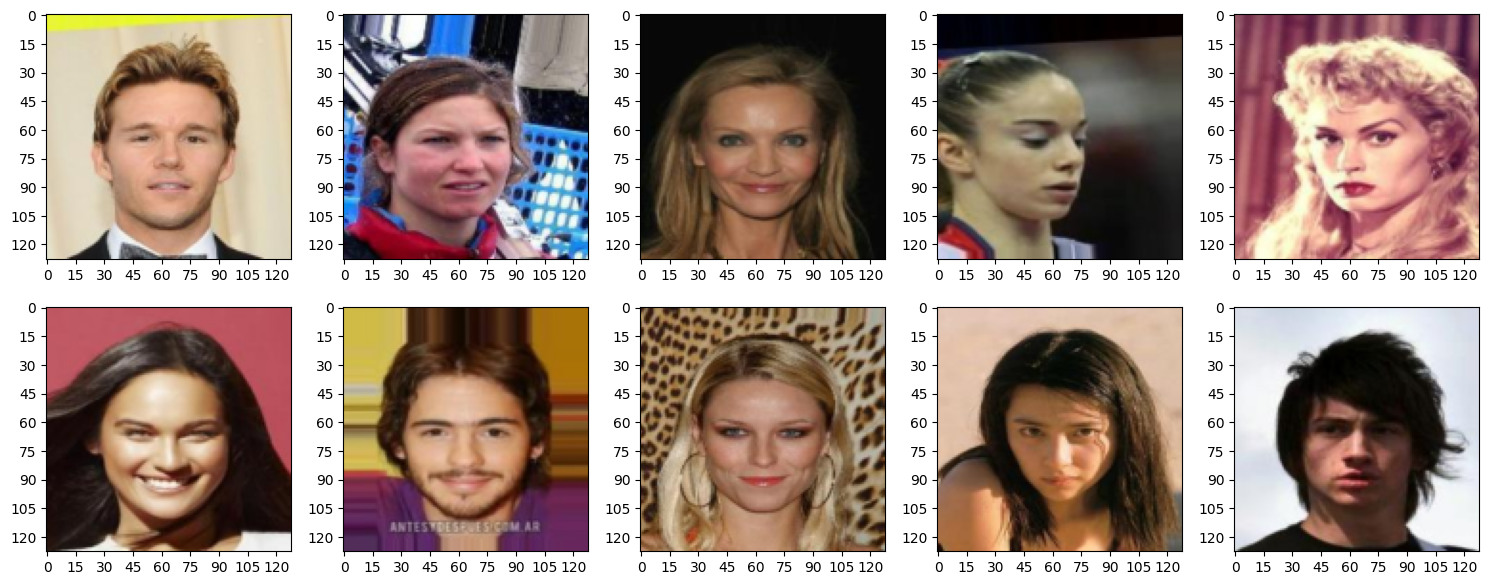

In [65]:
# Example usage with a batch of images
for hr_real, lr_real in train_dataloader:
    show_images(hr_real[:10], lr_real[:10])
    break

## SRGAN Architecture

The VAE-GAN combines the Variational Autoencoder (VAE) with a Generative Adversarial Network (GAN) to improve the quality of generated images. The VAE acts as the generator, and the GAN discriminator ensures the generated images are realistic.

### Residual Block

This block consists of two convolutional layers with a residual connection to help with the flow of gradients. Residual blocks are important for deep networks as they help to mitigate the vanishing gradient problem.

In [66]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.SiLU(),  
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        # Return the input with the residual connection added to the output of the block
        return x + self.layers(x)

### Generator (SRResNet)

This generator architecture increases the resolution of input images using residual blocks and PixelShuffle layers. The goal is to upscale low-resolution images to high-resolution images.

> ![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Generator.png?raw=true)
*SRGAN Generator, taken from Figure 4 of [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017).*

In [67]:
class Generator(nn.Module):
    def __init__(self, base_channels=64, n_ps_blocks=2, n_res_blocks=16):
        super().__init__()

        # Input layer
        self.in_layer = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=9, padding=4),
            nn.GELU(),  # GELU activation for non-linearity
        )

        # Residual blocks
        res_blocks = []
        for _ in range(n_res_blocks):
            res_blocks += [ResidualBlock(base_channels)]
        res_blocks += [
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
        ]
        self.res_blocks = nn.Sequential(*res_blocks)

        # PixelShuffle blocks (subpixel convolutions for upsampling)
        ps_blocks = []
        for _ in range(n_ps_blocks):
            ps_blocks += [
                nn.Conv2d(base_channels, 4 * base_channels, kernel_size=3, padding=1),
                nn.PixelShuffle(2),  # Upsample by a factor of 2
                nn.GELU(),  # GELU activation
            ]
        self.ps_blocks = nn.Sequential(*ps_blocks)

        # Output layer (Ensure output size is 128x128)
        self.out_layer = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=9, padding=4),
            nn.Tanh(),  # Tanh to get pixel values in the range [-1, 1]
        )

        # Upsample to ensure the output size is 128x128
        self.upsample = nn.Upsample(size=(128, 128), mode='bilinear', align_corners=False)

    def forward(self, x):
        x_res = self.in_layer(x)
        x = x_res + self.res_blocks(x_res)  # Add residual connection
        x = self.ps_blocks(x)
        x = self.out_layer(x)
        x = self.upsample(x)  # Ensure output size is 128x128
        return x

### Discriminator

The discriminator's task is to classify images as real or fake, providing feedback to the generator during training. We use a series of convolutional layers and LeakyReLU activations to classify the images.

In [68]:
class Discriminator(nn.Module):
    def __init__(self, base_channels=64, n_blocks=3):
        super().__init__()
        self.blocks = [
            nn.Conv2d(3, base_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation

            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        cur_channels = base_channels
        for i in range(n_blocks):
            self.blocks += [
                nn.Conv2d(cur_channels, 2 * cur_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(2 * cur_channels),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(2 * cur_channels, 2 * cur_channels, kernel_size=3, padding=1, stride=2),
                nn.BatchNorm2d(2 * cur_channels),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            cur_channels *= 2

        self.blocks += [
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(cur_channels, 2 * cur_channels, kernel_size=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2 * cur_channels, 1, kernel_size=1, padding=0),
            nn.Flatten(),
        ]

        self.layers = nn.Sequential(*self.blocks)

    def forward(self, x):
        return self.layers(x)

### Loss Functions

The loss function combines three terms:

1. **Content loss**: Measures the difference between high-resolution images and generated images using MSE.
2. **Adversarial loss**: Measures how well the discriminator can distinguish between real and generated images.
3. **Perceptual loss**: Measures the perceptual similarity between real and generated images using features from VGG19.

In [31]:
class Loss(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()

        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to(device)
        self.vgg = nn.Sequential(*list(vgg.features)[:-1]).eval()  # VGG19 feature extractor
        for p in self.vgg.parameters():
            p.requires_grad = False

    @staticmethod
    def img_loss(x_real, x_fake):
        return F.mse_loss(x_real, x_fake)

    def adv_loss(self, x, is_real):
        target = torch.zeros_like(x) if is_real else torch.ones_like(x)
        return F.binary_cross_entropy_with_logits(x, target)

    def vgg_loss(self, x_real, x_fake):
        return F.mse_loss(self.vgg(x_real), self.vgg(x_fake))

    def forward(self, generator, discriminator, hr_real, lr_real):
        hr_fake = generator(lr_real)
        fake_preds_for_g = discriminator(hr_fake)
        fake_preds_for_d = discriminator(hr_fake.detach())
        real_preds_for_d = discriminator(hr_real.detach())

        g_loss = (
            0.001 * self.adv_loss(fake_preds_for_g, False) + \
            0.006 * self.vgg_loss(hr_real, hr_fake) + \
            self.img_loss(hr_real, hr_fake)
        )
        d_loss = 0.5 * (
            self.adv_loss(real_preds_for_d, True) + \
            self.adv_loss(fake_preds_for_d, False)
        )

        return g_loss, d_loss, hr_fake

### Evaluation Metrics: PSNR and SSIM

We use Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index Measure (SSIM) to evaluate the quality of the generated high-resolution images.

In [69]:
# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(img1, img2, max_value=1.0):
    # Convert tensor images to numpy arrays and calculate MSE
    img1 = img1.detach().cpu().numpy()  # Detach from computation graph and convert to numpy
    img2 = img2.detach().cpu().numpy()  # Detach from computation graph and convert to numpy
    mse = np.mean((img1 - img2) ** 2)
    
    # Avoid division by zero
    if mse == 0:
        return 100  # If MSE is 0, return a PSNR of 100
    psnr = 10 * log10((max_value ** 2) / mse)  # Calculate PSNR
    return psnr

# Function to calculate SSIM (Structural Similarity Index)
def calculate_ssim(img1, img2, win_size=3, data_range=2):
    # Convert tensor images to numpy arrays
    img1 = img1.detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format for SSIM
    img2 = img2.detach().cpu().numpy().transpose(1, 2, 0)
    
    # Compute SSIM with a smaller window size (e.g., 3 or 5)
    return ssim(img1, img2, win_size=win_size, multichannel=True, data_range=data_range)

### Training the SRGAN

Training loop for both the generator and the discriminator. The optimizer used is AdamW, and we combine adversarial and perceptual loss for training.

In [33]:
def train(generator, discriminator, dataloader, device, lr=1e-4, total_steps=1e4, display_step=1000, patience=5, min_improvement=0.1, warmup_steps=5000):
    generator = generator.to(device).train()
    discriminator = discriminator.to(device).train()
    loss_fn = Loss(device=device)

    g_optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)
    d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=lr)

    cur_step = 0
    mean_g_loss = 0.0
    mean_d_loss = 0.0
    best_psnr = -float('inf')
    patience_counter = 0

    pbar = tqdm(total=int(total_steps), desc="Training Steps")

    while cur_step < total_steps:
        for hr_real, lr_real in dataloader:
            if cur_step >= total_steps:
                break

            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)

            # Forward + backward
            g_loss, d_loss, hr_fake = loss_fn(generator, discriminator, hr_real, lr_real)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            # Métricas de validación
            psnr_value = calculate_psnr(hr_real[0], hr_fake[0])
            ssim_value = calculate_ssim(hr_real[0], hr_fake[0], win_size=3, data_range=2)

            # Mostrar durante warmup también
            if cur_step % display_step == 0:
                tqdm.write(f'Step {cur_step}: G_loss: {mean_g_loss:.5f}, D_loss: {mean_d_loss:.5f}')
                tqdm.write(f'PSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.4f}')
                mean_g_loss = 0.0
                mean_d_loss = 0.0

            # Early stopping
            if cur_step >= warmup_steps:
                if psnr_value > best_psnr + min_improvement:
                    best_psnr = psnr_value
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    tqdm.write(f"🛑 Early stopping at step {cur_step} due to no improvement in PSNR.")
                    return

            cur_step += 1
            pbar.update(1)

    pbar.close()

### Start Training

Initialize and start training the model.

In [34]:
generator = Generator(n_res_blocks=16, n_ps_blocks=2).to(device)
discriminator = Discriminator(n_blocks=1, base_channels=8).to(device)

In [36]:
train(
    generator,  # Your generator model
    discriminator,  # Your discriminator model
    train_dataloader,  # Your dataloader for the dataset
    device,  # The device ('cuda' or 'cpu')
    lr=1e-4,  # Learning rate
    total_steps=1e4,  # Total steps to train
    display_step=1000,  # Display metrics every 1000 steps
    patience=5,  # Early stopping patience (number of steps without improvement in PSNR)
    min_improvement=0.1,  # Minimum PSNR improvement required to reset early stopping
    warmup_steps=5000  # Number of steps to warm up before early stopping is considered
)

Training Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Step 0: G_loss: 0.00035, D_loss: 0.00070
PSNR: 2.81 dB, SSIM: 0.0069
Step 1000: G_loss: 0.01311, D_loss: 0.67519
PSNR: 23.52 dB, SSIM: 0.9285
Step 2000: G_loss: 0.00366, D_loss: 0.31086
PSNR: 26.84 dB, SSIM: 0.9299
Step 3000: G_loss: 0.00254, D_loss: 0.03817
PSNR: 26.98 dB, SSIM: 0.9737
Step 4000: G_loss: 0.00216, D_loss: 0.01223
PSNR: 27.01 dB, SSIM: 0.9810
Step 5000: G_loss: 0.00190, D_loss: 0.00675
PSNR: 29.49 dB, SSIM: 0.9748
🛑 Early stopping at step 5005 due to no improvement in PSNR.


In [37]:
# Save the trained models
torch.save(generator.state_dict(), 'models/srgan/srgenerator.pth')
torch.save(discriminator.state_dict(), 'models/srgan/srdiscriminator.pth')

In [70]:
generator = Generator().to(device)
generator.load_state_dict(torch.load('models/srgan/srgenerator.pth', map_location=device))
generator.eval()

Generator(
  (in_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): GELU(approximate='none')
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [39]:
def evaluate(generator, test_loader, device):
    generator.eval()
    avg_psnr = 0.0
    avg_ssim = 0.0
    with torch.no_grad():
        for hr_real, lr_real in tqdm(test_loader, desc="Evaluating"):
            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)
            hr_fake = generator(lr_real)

            psnr_value = calculate_psnr(hr_real[0], hr_fake[0])
            ssim_value = calculate_ssim(hr_real[0], hr_fake[0], win_size=3, data_range=2)

            avg_psnr += psnr_value
            avg_ssim += ssim_value

    total = len(test_loader)
    avg_psnr /= total
    avg_ssim /= total
    print(f"\nEvaluation Results — PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim

In [71]:
def compare_images(generator, test_loader):
    """
    Compare low-resolution, super-resolution, and high-resolution images.

    Args:
        generator (nn.Module): The generator model.
        test_loader (DataLoader): DataLoader for the test dataset.

    Displays:
        A plot comparing 5 low-resolution, super-resolution, and high-resolution images.
    """

    def denormalize(tensor):
        # Convert image from [-1, 1] to [0, 1]
        return tensor * 0.5 + 0.5

    generator.eval()
    with torch.no_grad():
        for hr_real, lr_real in test_loader:
            lr_real = lr_real.to(device)
            sr_fake = generator(lr_real)

            # Display 5 low-resolution, super-resolution, and high-resolution images
            fig, axs = plt.subplots(3, 5, figsize=(15, 9))
            for i in range(5):
                lr_img = denormalize(lr_real[i].cpu()).permute(1, 2, 0).numpy()
                sr_img = denormalize(sr_fake[i].cpu()).permute(1, 2, 0).numpy()
                hr_img = denormalize(hr_real[i].cpu()).permute(1, 2, 0).numpy()

                axs[0, i].imshow(np.clip(lr_img, 0, 1))
                axs[0, i].set_title("Low Resolution")
                axs[0, i].axis("off")

                axs[1, i].imshow(np.clip(sr_img, 0, 1))
                axs[1, i].set_title("Super Resolution")
                axs[1, i].axis("off")

                axs[2, i].imshow(np.clip(hr_img, 0, 1))
                axs[2, i].set_title("High Resolution")
                axs[2, i].axis("off")

            plt.tight_layout()
            plt.show()
            break

In [72]:
# Evaluar en test set
evaluate(generator, test_dataloader, device)

Evaluating:   0%|          | 0/2533 [00:00<?, ?it/s]


Evaluation Results — PSNR: 28.73 dB | SSIM: 0.9638


(28.730613233150546, np.float64(0.963771197315034))

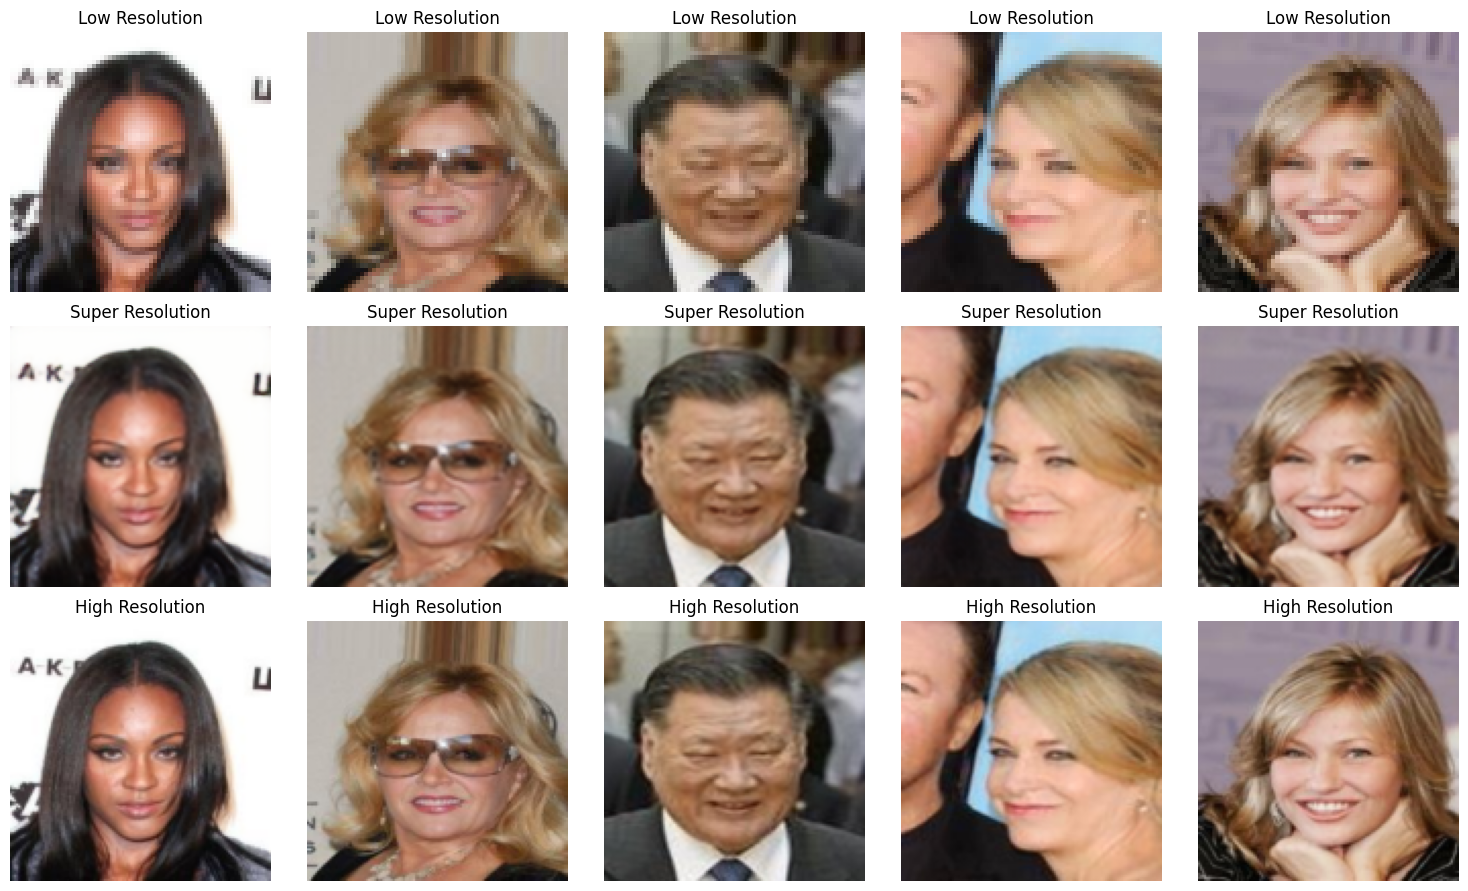

In [73]:
# Mostrar muestra
compare_images(generator, test_dataloader)

## Citation

```bibtex
@inproceedings{liu2015faceattributes,
  title = {Deep Learning Face Attributes in the Wild},
  author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},
  booktitle = {Proceedings of International Conference on Computer Vision (ICCV)},
  month = {December},
  year = {2015} 
}

```bibtex
@misc{ledig2017photorealisticsingleimagesuperresolution,
      title={Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network}, 
      author={Christian Ledig and Lucas Theis and Ferenc Huszar and Jose Caballero and Andrew Cunningham and Alejandro Acosta and Andrew Aitken and Alykhan Tejani and Johannes Totz and Zehan Wang and Wenzhe Shi},
      year={2017},
      eprint={1609.04802},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/1609.04802}, 
}